### Install dependencies and packages

In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor


#### Load Data

In [6]:
insurance_url = "/Users/dharshinisathiyendran/Documents/DS project/insurance.csv"
insurance_data = pd.read_csv(insurance_url)
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Analyse the data 

In [7]:
insurance_data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


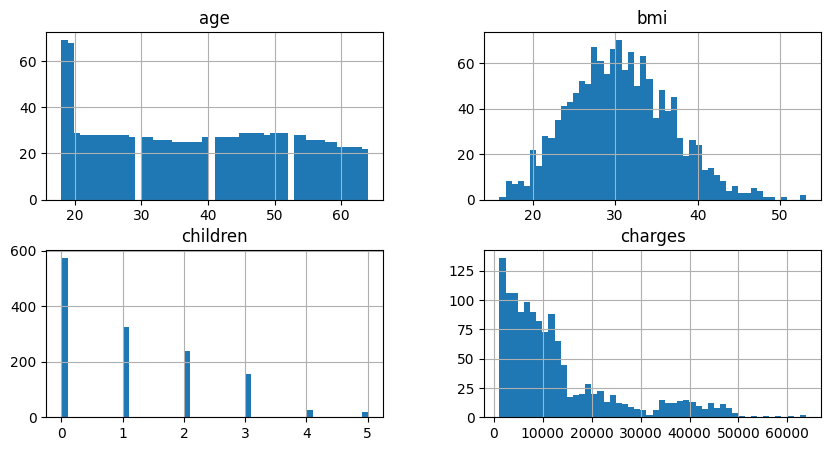

In [8]:
insurance_data.hist(figsize=(10,5), bins = 50)
plt.show()

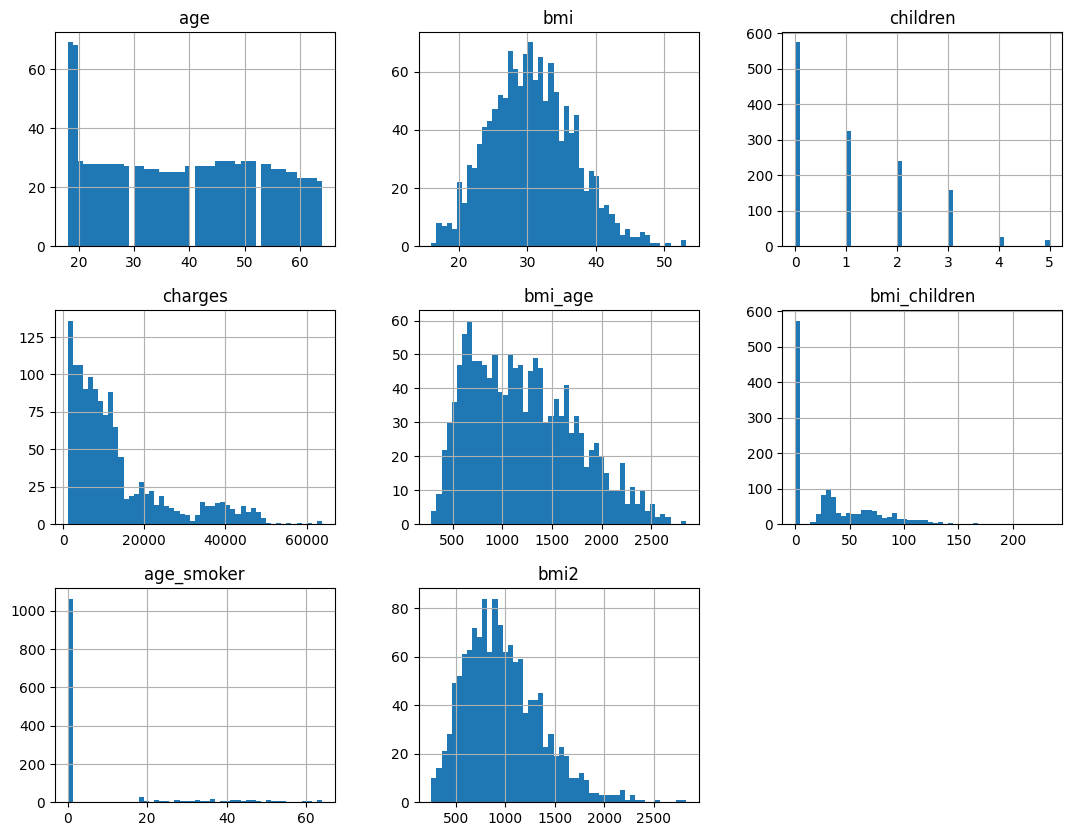

,age,bmi,children,charges,bmi_age,bmi_children,age_smoker,bmi2
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,1211.575919,33.667623,7.887145,977.403997
std,14.049960,6.098187,1.205493,12110.011237,522.608731,38.257222,16.772800,387.865337
min,18.000000,15.960000,0.000000,1121.873900,287.280000,0.000000,0.000000,254.721600
25%,27.000000,26.296250,0.000000,4740.287150,765.625000,0.000000,0.000000,691.492881
50%,39.000000,30.400000,1.000000,9382.033000,1152.225000,27.360000,0.000000,924.160000
75%,51.000000,34.693750,2.000000,16639.912515,1589.085000,59.830000,0.000000,1203.656406
max,64.000000,53.130000,5.000000,63770.428010,2845.480000,233.750000,64.000000,2822.796900


In [36]:
insurance_data['bmi_age'] = insurance_data['bmi'] * insurance_data['age']
insurance_data['bmi_children'] = insurance_data['bmi'] * insurance_data['children']
insurance_data['age_smoker'] = insurance_data['age'] * (insurance_data['smoker'] == 'yes').astype(int)
insurance_data['bmi2'] = insurance_data['bmi'] ** 2
insurance_data.hist(figsize=(13,10), bins = 50)
plt.show()
insurance_data.describe()

In [10]:
age_cat = pd.cut(insurance_data['age'], bins=[17, 25, 30, 40, 50, 65], labels=[1,2,3,4,5] )
age_cat.value_counts()

age
5    356
1    306
4    281
3    257
2    138
Name: count, dtype: int64

#### Split train and test data

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
split_object = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
gen_obj = split_object.split(insurance_data, age_cat)
train_ind,test_ind = next(gen_obj)
strat_train_set = insurance_data.loc[train_ind]
strat_test_set = insurance_data.loc[test_ind]

In [12]:
train_copy = strat_train_set.copy()
train_copy.count()

age             1070
sex             1070
bmi             1070
children        1070
smoker          1070
region          1070
charges         1070
bmi_age         1070
bmi_children    1070
age_smoker      1070
bmi2            1070
dtype: int64

<Axes: xlabel='age', ylabel='charges'>

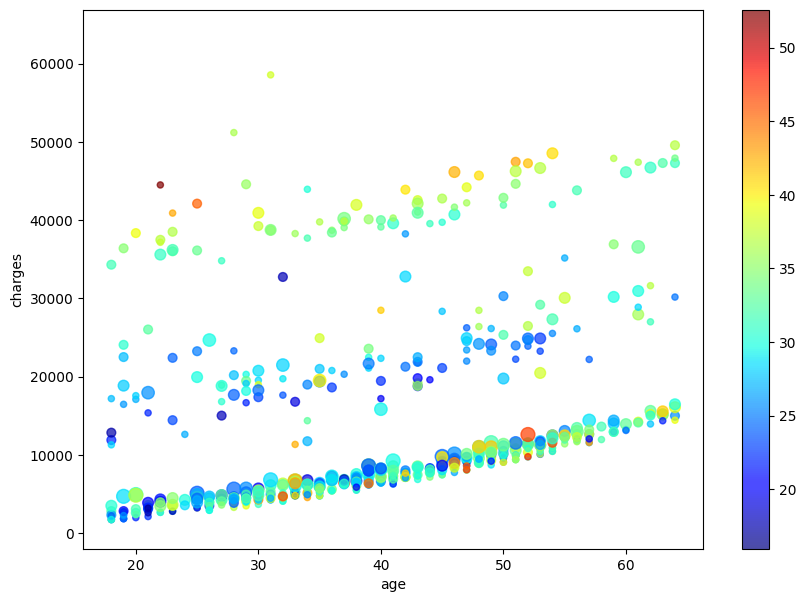

In [13]:
train_copy.plot(kind='scatter', x='age', y='charges', alpha = 0.7, figsize=(10,7), colorbar=True, s=train_copy["children"]*20, c=train_copy['bmi'], cmap = plt.get_cmap("jet"))

In [15]:
train_data = strat_train_set.drop("charges", axis = 1)
train_labels = strat_train_set["charges"].copy()
test_data = strat_test_set.drop("charges", axis = 1)
test_labels = strat_test_set["charges"].copy()
train_labels.count(), test_labels.count()

(1070, 268)

*Check if there's any missing data*

In [16]:
train_data.count()

age             1070
sex             1070
bmi             1070
children        1070
smoker          1070
region          1070
bmi_age         1070
bmi_children    1070
age_smoker      1070
bmi2            1070
dtype: int64

In [17]:
num_data = strat_train_set.drop(columns=["sex","region","smoker"], axis=1).copy()
num_data.corr()

,age,bmi,children,charges,bmi_age,bmi_children,age_smoker,bmi2
age,1.000000,0.127636,0.036156,0.279371,0.883407,0.062153,0.146949,0.121730
bmi,0.127636,1.000000,0.019641,0.201091,0.550167,0.196249,-0.007310,0.992206
children,0.036156,0.019641,1.000000,0.055920,0.043480,0.966589,-0.003977,0.022379
charges,0.279371,0.201091,0.055920,1.000000,0.311764,0.088990,0.791989,0.196988
bmi_age,0.883407,0.550167,0.043480,0.311764,1.000000,0.144101,0.109962,0.544898
bmi_children,0.062153,0.196249,0.966589,0.088990,0.144101,1.000000,-0.005427,0.198780
age_smoker,0.146949,-0.007310,-0.003977,0.791989,0.109962,-0.005427,1.000000,-0.005898
bmi2,0.121730,0.992206,0.022379,0.196988,0.544898,0.198780,-0.005898,1.000000


### Data pre-processing

*Since there is no missing data, skip impute*

In [19]:
categorical_cols = ['sex', 'smoker', 'region']
numerical_cols = ['age', 'bmi', 'children', 'bmi_age', 'bmi_children', 'age_smoker', 'bmi2']

In [20]:
from sklearn.preprocessing import *
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()
preprocess_pipeline = ColumnTransformer(
    transformers=[
        ('std_scaler', numerical_transformer, numerical_cols),
        ('onehot_encoder', categorical_transformer, categorical_cols)
    ])
insurance_transformed = preprocess_pipeline.fit_transform(train_data)
insurance_train_prepared = insurance_transformed.copy()
insurance_test_prepared = preprocess_pipeline.fit_transform(test_data).copy()

#### Train models and compare

In [21]:
from sklearn.linear_model import *
from sklearn.model_selection import cross_val_score
lin_reg = LinearRegression()
lin_reg.fit(insurance_train_prepared, train_labels)
predictions = lin_reg.predict(insurance_train_prepared)
lin_rmse = mean_squared_error(train_labels, predictions, squared = False)
lin_rmse

scores = abs(cross_val_score(lin_reg, insurance_train_prepared, train_labels, scoring="neg_root_mean_squared_error", 
               cv = 10))
print(scores.mean())

5929.866755449707


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(insurance_train_prepared, train_labels)
predictions = tree_reg.predict(insurance_train_prepared)
tree_rmse = mean_squared_error(train_labels, predictions, squared = False)
tree_rmse

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


494.20598375812835

In [23]:
from sklearn.model_selection import cross_val_score
scores = abs(cross_val_score(tree_reg, insurance_train_prepared, train_labels, scoring="neg_root_mean_squared_error", 
               cv = 10))
scores.mean()

6029.103461511266

*Decision Tree regression model is overfitting - validated by kfold cross validation*

In [24]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(insurance_train_prepared, train_labels)
predictions = forest_reg.predict(insurance_train_prepared)
forest_rmse = mean_squared_error(train_labels, predictions, squared = False)
forest_rmse

scores = abs(cross_val_score(forest_reg, insurance_train_prepared, train_labels, scoring="neg_root_mean_squared_error", 
               cv = 10))
scores.mean()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4571.199771588157

#### Ensembling and Evaluation

In [25]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), ('regressor', model)])
    mse, rmse, r2 = evaluate_model(pipeline, train_data, test_data, train_labels, test_labels)
    results[name] = {'MSE': mse, 'RMSE': rmse, 'R-squared': r2}

for name, result in results.items():
    print(f'{name}: MSE={result["MSE"]}, RMSE={result["RMSE"]}, R-squared={result["R-squared"]}')

Linear Regression: MSE=43963923.18837758, RMSE=6630.529631060975, R-squared=0.6912200028388003
Random Forest: MSE=30455887.454206944, RMSE=5518.685301247657, R-squared=0.7860935021345421
Gradient Boosting: MSE=28118574.134302877, RMSE=5302.6949878625755, R-squared=0.802509589415752
XGBoost: MSE=33367554.894296374, RMSE=5776.46560573993, R-squared=0.7656434467554342


In [26]:
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30]
}
pipeline_rf = Pipeline(steps=[('preprocessor', preprocess_pipeline), ('regressor', RandomForestRegressor(random_state=42))])
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(train_data, train_labels)

param_grid_gb = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}
pipeline_gb = Pipeline(steps=[('preprocessor', preprocess_pipeline), ('regressor', GradientBoostingRegressor(random_state=42))])
grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gb.fit(train_data, train_labels)

param_grid_xgb = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocess_pipeline), ('regressor', XGBRegressor(random_state=42))])
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb.fit(train_data, train_labels)

print("Best parameters for (Random Forest):", grid_search_rf.best_params_)
print("Best parameters for (Gradient Boosting):", grid_search_gb.best_params_)
print("Best parameters for (XGBoost):", grid_search_xgb.best_params_)

best_rf = grid_search_rf.best_estimator_
best_gb = grid_search_gb.best_estimator_
best_xgb = grid_search_xgb.best_estimator_

fine_tuned_models = {'Random Forest': best_rf, 'Gradient Boosting': best_gb, 'XGBoost': best_xgb}
for name, model in fine_tuned_models.items():
    mse, rmse, r2 = evaluate_model(model, train_data, test_data, train_labels, test_labels)
    print(f'{name} (Fine-Tuned): MSE={mse}, RMSE={rmse}, R-squared={r2}')

Best parameters for (Random Forest): {'regressor__max_depth': 10, 'regressor__n_estimators': 200}
Best parameters for (Gradient Boosting): {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
Best parameters for (XGBoost): {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
Random Forest (Fine-Tuned): MSE=29716377.163798813, RMSE=5451.272985624441, R-squared=0.7912874422748358
Gradient Boosting (Fine-Tuned): MSE=27227352.308100972, RMSE=5217.983548086461, R-squared=0.8087690733973221
XGBoost (Fine-Tuned): MSE=26835540.675211746, RMSE=5180.303145107605, R-squared=0.8115209568990028


In [27]:
from sklearn.ensemble import VotingRegressor

ensemble = VotingRegressor(estimators=[
    ('gb', best_gb),
    ('xgb', best_xgb)
])

ensemble.fit(train_data, train_labels)
predicted_ensemble = ensemble.predict(test_data)

mse_ensemble = mean_squared_error(test_labels, predicted_ensemble)
rmse_ensemble = np.sqrt(mse_ensemble)
r2_ensemble = r2_score(test_labels, predicted_ensemble)

print(f'Ensemble Model: MSE={mse_ensemble}, RMSE={rmse_ensemble}, R-squared={r2_ensemble}')

Ensemble Model: MSE=26967302.683015127, RMSE=5193.005168783787, R-squared=0.8105955282874308


*XGBoost is better than ensemble model. So we'll consider that our final model*

#### Final model

In [28]:
predicted = grid_search_xgb.predict(test_data)

mse_grid_search_xgb = mean_squared_error(test_labels, predicted)
rmse_grid_search_xgb = np.sqrt(mse_grid_search_xgb)
r2_grid_search_xgb = r2_score(test_labels, predicted)

print(f'XGB Model: MSE={mse_grid_search_xgb}, RMSE={rmse_grid_search_xgb}, R-squared={r2_grid_search_xgb}')

XGB Model: MSE=26835540.675211746, RMSE=5180.303145107605, R-squared=0.8115209568990028


#### Plot actual vs predicted results

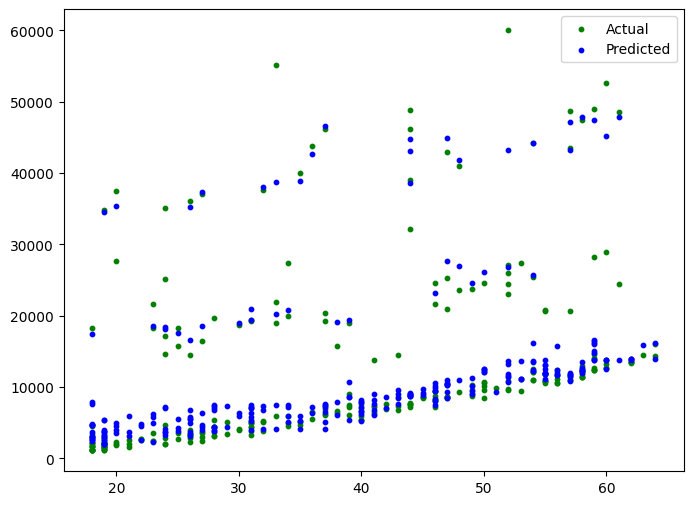

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(test_data['age'], test_labels, label="Actual", color='green', s=10)
plt.scatter(test_data['age'], predicted, label="Predicted", color='blue', s=10)
plt.legend()
plt.show()